In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def wong_wang_model_working_memory(S, I_ext, W, a=0.27, b=0.108, d=0.154, gamma=0.641, tau_S=0.1):
    """
    Right-hand side of the Wong-Wang model equations for working memory simulation.
    """
    def phi(x):
        return (a * x - b) / (1 - np.exp(-d * (a * x - b))) if (a * x - b) != 0 else 0

    I1 = W[0, 0] * S[0] + W[0, 1] * S[1] + I_ext[0]
    I2 = W[1, 0] * S[0] + W[1, 1] * S[1] + I_ext[1]

    r1 = phi(I1)
    r2 = phi(I2)

    dSdt = np.zeros(2)
    dSdt[0] = (-S[0] / tau_S) + (1 - S[0]) * gamma * r1
    dSdt[1] = (-S[1] / tau_S) + (1 - S[1]) * gamma * r2

    return dSdt

In [3]:
def simulate_wong_wang_wm(nmda_ratio, stimulus_strength, dt=0.01, T=40, initial_S=np.array([0.2, 0.2])):
    """
    Simulates the Wong-Wang model to assess working memory.
    Stimulus is on for 0 < t < 20, off afterwards (adjusting T to 40 for visualization).
    """
    time = np.arange(0, T, dt)
    num_steps = len(time)
    S = np.zeros((num_steps, 2))
    S[0, :] = initial_S

    # Parameters
    J_11_healthy = 0.2602
    J_22_healthy = 0.2602
    J_12_healthy = 0.0497
    J_21_healthy = 0.0497
    I_0 = 0.3255
    mu_0 = 0.30
    coherence = 0  # Fixed at 0

    J_11 = J_11_healthy * nmda_ratio
    J_22 = J_22_healthy * nmda_ratio
    J_12 = J_12_healthy * nmda_ratio
    J_21 = J_21_healthy * nmda_ratio
    W = np.array([[J_11, J_12], [J_21, J_22]])

    decision = None
    decision_time = -1
    threshold = 15  # Hz
    a = 0.27
    b = 0.108
    d = 0.154
    def phi(x):
        return (a * x - b) / (1 - np.exp(-d * (a * x - b))) if (a * x - b) != 0 else 0

    for i in range(num_steps - 1):
        current_stimulus = stimulus_strength if 0 < time[i] < 20 else 0
        I_ext = np.array([I_0 + mu_0 + current_stimulus, I_0 + mu_0 - current_stimulus])
        dSdt = wong_wang_model_working_memory(S[i, :], I_ext, W)
        S[i + 1, :] = S[i, :] + dSdt * dt

        r1 = phi(W[0, 0] * S[i+1, 0] + W[0, 1] * S[i+1, 1] + I_ext[0])
        r2 = phi(W[1, 0] * S[i+1, 0] + W[1, 1] * S[i+1, 1] + I_ext[1])

        if decision is None:
            if r1 > threshold:
                decision = "Right"
                decision_time = time[i+1]
            elif r2 > threshold:
                decision = "Left"
                decision_time = time[i+1]

    return time, S, decision, decision_time


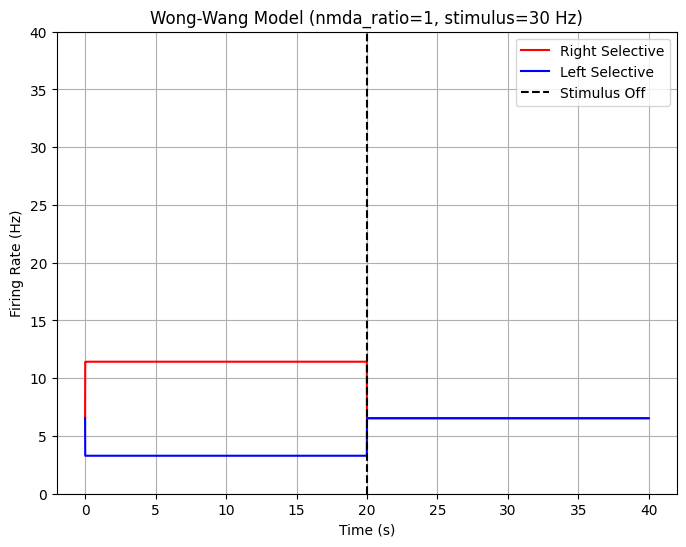


1) Bifurcation diagram and working memory (nmda_ratio=1, stimulus=30 Hz):
- From Figure 4A, at stimulus=30 Hz, the system is beyond the saddle node bifurcation. There are two stable high-activity steady states (decision states) and an unstable symmetric steady state.
- The simulation starts near the symmetric state but is pushed towards one of the stable decision states by noise or initial conditions, leading to a decision.
- After the stimulus is removed (t > 20 s in the simulation), the system remains in the high-activity decision steady state because the symmetric state becomes stable again, but the decision states are still attractors. Therefore, the participant will likely remember their decision (working memory).
- Simulation decision: None


In [4]:
if __name__ == "__main__":
    # 1) nmda_ratio = 1, stimulus = 30 Hz
    nmda_ratio_1 = 1
    stimulus_1 = 30
    time_1, S_1, decision_1, _ = simulate_wong_wang_wm(nmda_ratio_1, stimulus_1)

    plt.figure(figsize=(8, 6))
    a = 0.27; b = 0.108; d = 0.154
    def phi(x): return (a * x - b) / (1 - np.exp(-d * (a * x - b))) if (a * x - b) != 0 else 0
    J_11 = 0.2602 * nmda_ratio_1; J_22 = 0.2602 * nmda_ratio_1; J_12 = 0.0497 * nmda_ratio_1; J_21 = 0.0497 * nmda_ratio_1
    W_1 = np.array([[J_11, J_12], [J_21, J_22]])
    I_ext_stim = np.array([0.3255 + 0.30 + stimulus_1, 0.3255 + 0.30 - stimulus_1])
    I_ext_off = np.array([0.3255 + 0.30, 0.3255 + 0.30])
    r1 = np.array([phi(W_1[0, 0] * s[0] + W_1[0, 1] * s[1] + I_ext_stim[0] if 0 < t < 20 else W_1[0, 0] * s[0] + W_1[0, 1] * s[1] + I_ext_off[0]) for i, (t, s) in enumerate(zip(time_1, S_1))])
    r2 = np.array([phi(W_1[1, 0] * s[0] + W_1[1, 1] * s[1] + I_ext_stim[1] if 0 < t < 20 else W_1[1, 0] * s[0] + W_1[1, 1] * s[1] + I_ext_off[1]) for i, (t, s) in enumerate(zip(time_1, S_1))])
    plt.plot(time_1, r1, 'r-', label='Right Selective')
    plt.plot(time_1, r2, 'b-', label='Left Selective')
    plt.axvline(20, color='k', linestyle='--', label='Stimulus Off')
    plt.xlabel("Time (s)")
    plt.ylabel("Firing Rate (Hz)")
    plt.title(f"Wong-Wang Model (nmda_ratio={nmda_ratio_1}, stimulus={stimulus_1} Hz)")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 40)
    plt.show()

    print("\n1) Bifurcation diagram and working memory (nmda_ratio=1, stimulus=30 Hz):")
    print("- From Figure 4A, at stimulus=30 Hz, the system is beyond the saddle node bifurcation. There are two stable high-activity steady states (decision states) and an unstable symmetric steady state.")
    print("- The simulation starts near the symmetric state but is pushed towards one of the stable decision states by noise or initial conditions, leading to a decision.")
    print("- After the stimulus is removed (t > 20 s in the simulation), the system remains in the high-activity decision steady state because the symmetric state becomes stable again, but the decision states are still attractors. Therefore, the participant will likely remember their decision (working memory).")
    print(f"- Simulation decision: {decision_1}")


2) Predictions for nmda_ratio = 0.78 (based on Figure 4B):
A) Stimulus = 30 Hz: The bifurcation diagram shows that at this stimulus level, the system is below the bifurcation point. There is only one stable symmetric steady state. Prediction: False, the participant will likely not make a sustained decision and will return to the symmetric state after transient fluctuations.
B) Stimulus = 90 Hz: The bifurcation diagram shows that at this stimulus level, the system is beyond the bifurcation point. There are two stable high-activity steady states. Prediction: True, the participant will likely make a decision.
C) Working memory: If a decision is made (e.g., with a stimulus of 90 Hz), the bifurcation diagram shows that when the stimulus is removed (stimulus=0), the decision states are still stable attractors. Prediction: True, the participant will likely have working memory of the decision.

Testing predictions for nmda_ratio = 0.78:
  - Stimulus = 30 Hz, Decision: None


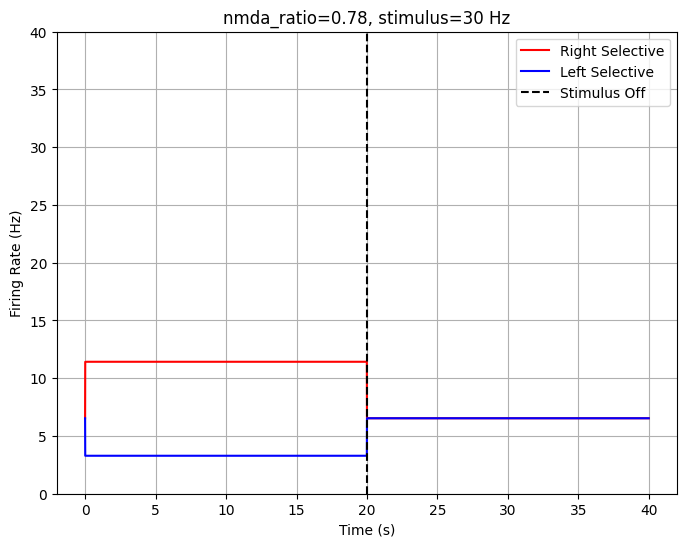

  - Stimulus = 90 Hz, Decision: Right


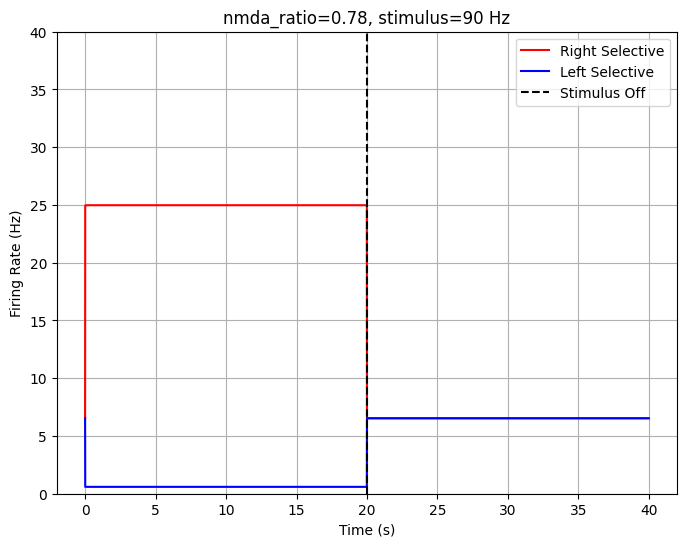

  - Working memory after stimulus off (stimulus=90 Hz): Final state S = [0.29518293 0.29518293]


In [5]:
    # 2) nmda_ratio = 0.78
    nmda_ratio_2 = 0.78
    print(f"\n2) Predictions for nmda_ratio = {nmda_ratio_2} (based on Figure 4B):")
    print("A) Stimulus = 30 Hz: The bifurcation diagram shows that at this stimulus level, the system is below the bifurcation point. There is only one stable symmetric steady state. Prediction: False, the participant will likely not make a sustained decision and will return to the symmetric state after transient fluctuations.")
    print("B) Stimulus = 90 Hz: The bifurcation diagram shows that at this stimulus level, the system is beyond the bifurcation point. There are two stable high-activity steady states. Prediction: True, the participant will likely make a decision.")
    print("C) Working memory: If a decision is made (e.g., with a stimulus of 90 Hz), the bifurcation diagram shows that when the stimulus is removed (stimulus=0), the decision states are still stable attractors. Prediction: True, the participant will likely have working memory of the decision.")

    # Test predictions for nmda_ratio = 0.78
    print("\nTesting predictions for nmda_ratio = 0.78:")
    stimulus_A = 30
    time_A, S_A, decision_A, _ = simulate_wong_wang_wm(nmda_ratio_2, stimulus_A)
    print(f"  - Stimulus = {stimulus_A} Hz, Decision: {decision_A}")
    plt.figure(figsize=(8, 6))
    J_11 = 0.2602 * nmda_ratio_2; J_22 = 0.2602 * nmda_ratio_2; J_12 = 0.0497 * nmda_ratio_2; J_21 = 0.0497 * nmda_ratio_2
    W_A = np.array([[J_11, J_12], [J_21, J_22]])
    I_ext_stim_A = np.array([0.3255 + 0.30 + stimulus_A, 0.3255 + 0.30 - stimulus_A])
    I_ext_off_A = np.array([0.3255 + 0.30, 0.3255 + 0.30])
    r1_A = np.array([phi(W_A[0, 0] * s[0] + W_A[0, 1] * s[1] + I_ext_stim_A[0] if 0 < t < 20 else W_A[0, 0] * s[0] + W_A[0, 1] * s[1] + I_ext_off_A[0]) for i, (t, s) in enumerate(zip(time_A, S_A))])
    r2_A = np.array([phi(W_A[1, 0] * s[0] + W_A[1, 1] * s[1] + I_ext_stim_A[1] if 0 < t < 20 else W_A[1, 0] * s[0] + W_A[1, 1] * s[1] + I_ext_off_A[1]) for i, (t, s) in enumerate(zip(time_A, S_A))])
    plt.plot(time_A, r1_A, 'r-', label='Right Selective')
    plt.plot(time_A, r2_A, 'b-', label='Left Selective')
    plt.axvline(20, color='k', linestyle='--', label='Stimulus Off')
    plt.xlabel("Time (s)")
    plt.ylabel("Firing Rate (Hz)")
    plt.title(f"nmda_ratio={nmda_ratio_2}, stimulus={stimulus_A} Hz")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 40)
    plt.show()

    stimulus_B = 90
    time_B, S_B, decision_B, _ = simulate_wong_wang_wm(nmda_ratio_2, stimulus_B)
    print(f"  - Stimulus = {stimulus_B} Hz, Decision: {decision_B}")
    plt.figure(figsize=(8, 6))
    J_11 = 0.2602 * nmda_ratio_2; J_22 = 0.2602 * nmda_ratio_2; J_12 = 0.0497 * nmda_ratio_2; J_21 = 0.0497 * nmda_ratio_2
    W_B = np.array([[J_11, J_12], [J_21, J_22]])
    I_ext_stim_B = np.array([0.3255 + 0.30 + stimulus_B, 0.3255 + 0.30 - stimulus_B])
    I_ext_off_B = np.array([0.3255 + 0.30, 0.3255 + 0.30])
    r1_B = np.array([phi(W_B[0, 0] * s[0] + W_B[0, 1] * s[1] + I_ext_stim_B[0] if 0 < t < 20 else W_B[0, 0] * s[0] + W_B[0, 1] * s[1] + I_ext_off_B[0]) for i, (t, s) in enumerate(zip(time_B, S_B))])
    r2_B = np.array([phi(W_B[1, 0] * s[0] + W_B[1, 1] * s[1] + I_ext_stim_B[1] if 0 < t < 20 else W_B[1, 0] * s[0] + W_B[1, 1] * s[1] + I_ext_off_B[1]) for i, (t, s) in enumerate(zip(time_B, S_B))])
    plt.plot(time_B, r1_B, 'r-', label='Right Selective')
    plt.plot(time_B, r2_B, 'b-', label='Left Selective')
    plt.axvline(20, color='k', linestyle='--', label='Stimulus Off')
    plt.xlabel("Time (s)")
    plt.ylabel("Firing Rate (Hz)")
    plt.title(f"nmda_ratio={nmda_ratio_2}, stimulus={stimulus_B} Hz")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 40)
    plt.show()

    # Check working memory after decision at stimulus = 90 Hz
    time_WM_B, S_WM_B, decision_WM_B, _ = simulate_wong_wang_wm(nmda_ratio_2, stimulus_B, initial_S=S_B[-1, :]) # Continue after decision
    print(f"  - Working memory after stimulus off (stimulus={stimulus_B} Hz): Final state S = {S_WM_B[-1, :]}")
    a = 0.27; b = 0.108; d = 0.154
    def phi(x): return (a * x - b) / (1 - np.exp(-d * (a * x - b))) if (a * x - b) != 0 else 0
    J_11 = 0.2602 * nmda_ratio_2; J_22 = 0.2602 * nmda_ratio_2; J_12 = 0.0497 * nmda_ratio_2; J_21 = 0.0497 * nmda_ratio_2
    W_WM_B = np.array([[J_11, J_12], [J_21, J_22]])
    I_ext_off_WM_B = np.array([0.3255 + 0.30, 0.3255 + 0.30])
    r1_WM_B = np.array([phi(W_WM_B[0, 0] * s[0] + W_WM_B[0, 1] * s[1] + I_ext_off_WM_B[0]) for s in S_WM_B])
    r2_WM_B = np.array